In [0]:
# Library
import numpy as np
import h5py
import matplotlib.pyplot as plt

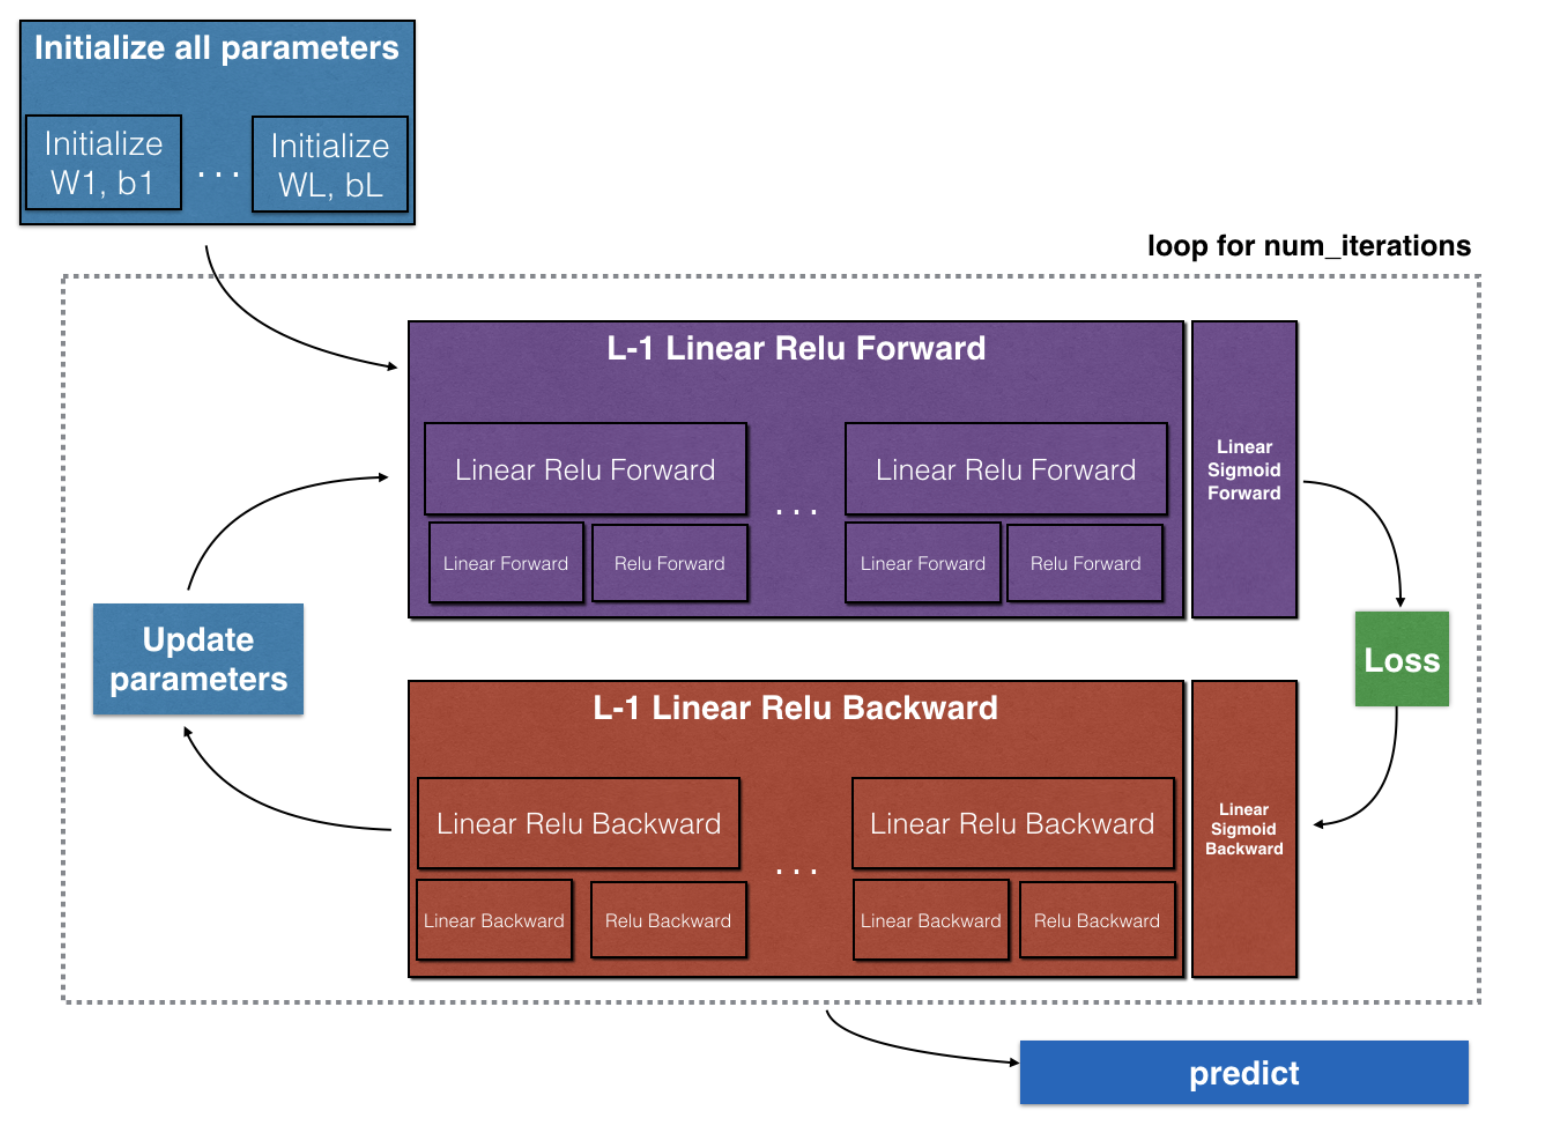

# 4 - Backward Propagation 

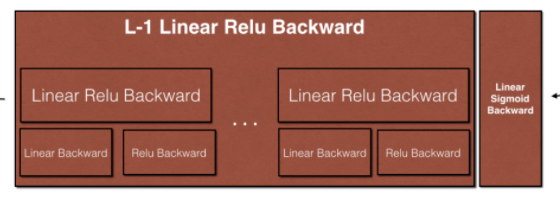

Just like with forward propagation, you will implement helper functions for backpropagation. Remember that back propagation is used to calculate the gradient of the loss function with respect to the parameters.

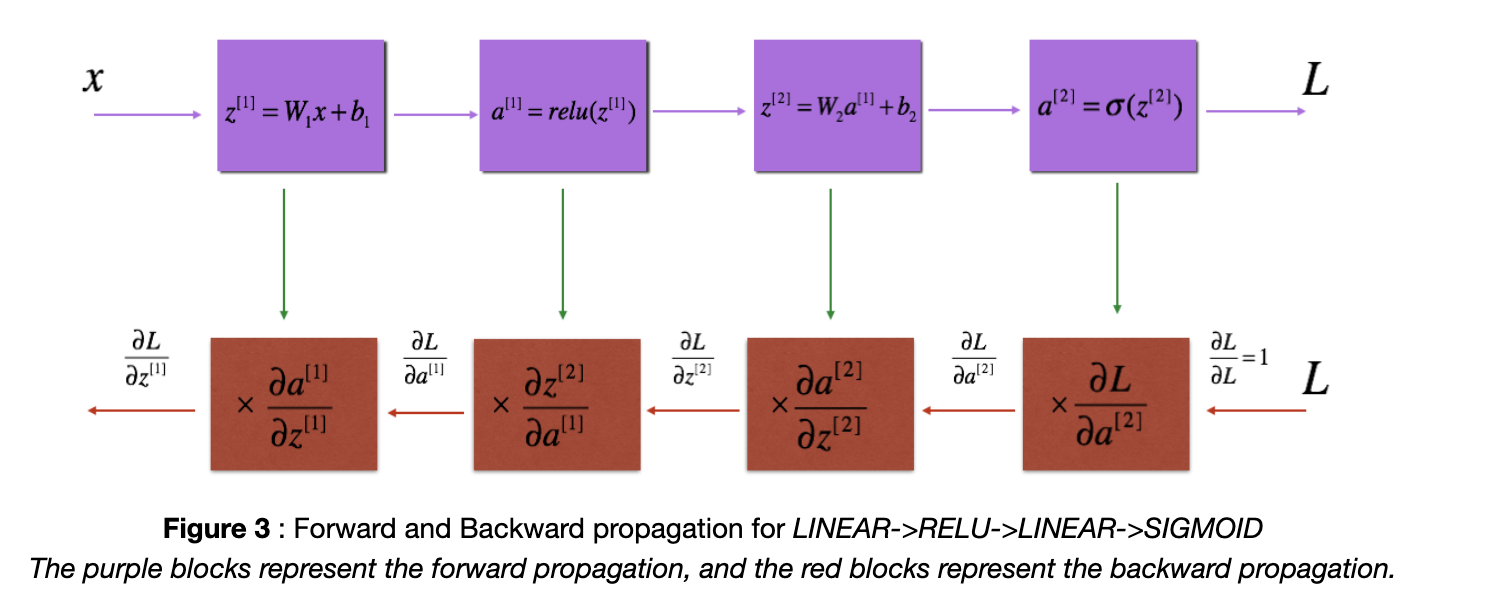

## Linear Backward

For layer $l$, the linear part is: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ (followed by an activation).

Suppose you have already calculated the derivative $dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$. You want to get $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$.





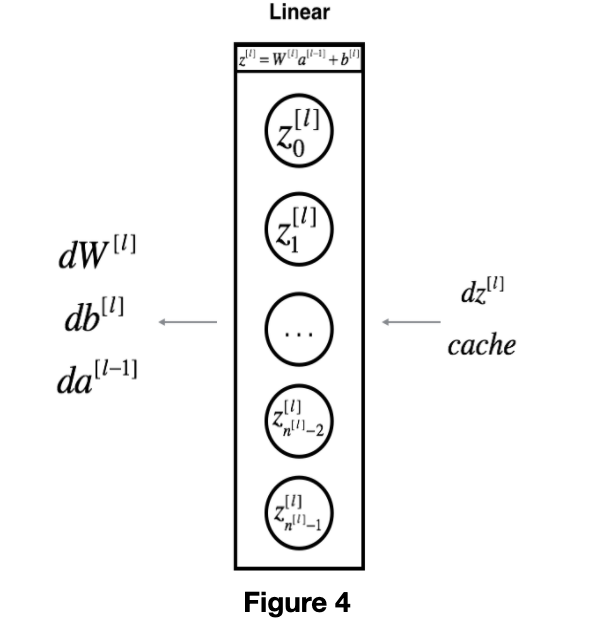

The three outputs $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$ are computed using the input $dZ^{[l]}$.Here are the formulas you need:
$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{8}$$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{9}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{10}$$

In [0]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    ### START CODE HERE ### (≈ 3 lines of code)
    dW = np.dot(dZ, cache[0].T) / m
    db = np.squeeze(np.sum(dZ, axis=1, keepdims=True)) / m
    dA_prev = np.dot(cache[1].T, dZ)
    ### END CODE HERE ###
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (isinstance(db, float))
    
    return dA_prev, dW, db

## Linear-Activation Backward

Next, you will create a function that merges the two helper functions: **`linear_backward`** and the backward step for the activation **`linear_activation_backward`**. 

To help you implement `linear_activation_backward`, we provided two backward functions:
- **`sigmoid_backward`**: Implements the backward propagation for SIGMOID unit. You can call it as follows:

```python
dZ = sigmoid_backward(dA, activation_cache)
```

- **`relu_backward`**: Implements the backward propagation for RELU unit. You can call it as follows:

```python
dZ = relu_backward(dA, activation_cache)
```

If $g(.)$ is the activation function, 
`sigmoid_backward` and `relu_backward` compute $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}) \tag{11}$$.  

**Exercise**: Implement the backpropagation for the *LINEAR->ACTIVATION* layer.

In [0]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ = relu_backward(dA, activation_cache)
        ### END CODE HERE ###
        
    elif activation == "sigmoid":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ = sigmoid_backward(dA, activation_cache)
        ### END CODE HERE ###
    
    # Shorten the code
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

## L-Model Backward

Now you will implement the backward function for the whole network. Recall that when you implemented the `L_model_forward` function, at each iteration, you stored a cache which contains (X,W,b, and z). In the back propagation module, you will use those variables to compute the gradients. Therefore, in the `L_model_backward` function, you will iterate through all the hidden layers backward, starting from layer $L$. On each step, you will use the cached values for layer $l$ to backpropagate through layer $l$. Figure 5 below shows the backward pass. 

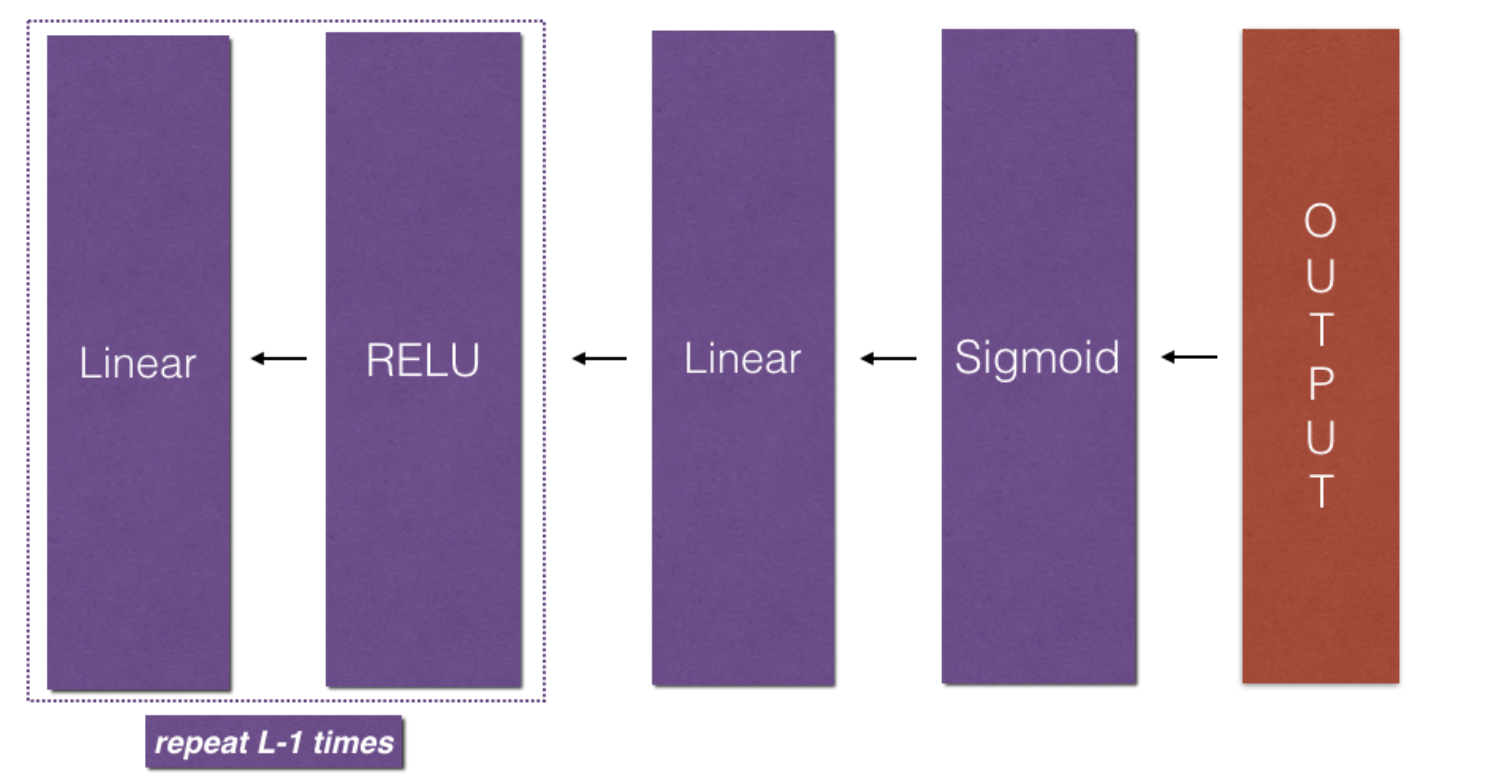

** Initializing backpropagation**:
To backpropagate through this network, we know that the output is, 
$A^{[L]} = \sigma(Z^{[L]})$. Your code thus needs to compute `dAL` $= \frac{\partial \mathcal{L}}{\partial A^{[L]}}$.
To do so, use this formula (derived using calculus which you don't need in-depth knowledge of):
```python
dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
```

You can then use this post-activation gradient `dAL` to keep going backward. As seen in Figure 5, you can now feed in `dAL` into the LINEAR->SIGMOID backward function you implemented (which will use the cached values stored by the L_model_forward function). After that, you will have to use a `for` loop to iterate through all the other layers using the LINEAR->RELU backward function. You should store each dA, dW, and db in the grads dictionary. To do so, use this formula : 

$$grads["dW" + str(l)] = dW^{[l]}\tag{15} $$

For example, for $l=3$ this would store $dW^{[l]}$ in `grads["dW3"]`.


In [0]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    ### START CODE HERE ### (1 line of code)
    dAL = dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    ### END CODE HERE ###
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    ### START CODE HERE ### (approx. 2 lines)
    current_cache = caches[-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_backward(sigmoid_backward(dAL, 
                                                                                                        current_cache[1]), 
                                                                                       current_cache[0])
    ### END CODE HERE ###
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 2)], caches". Outputs: "grads["dA" + str(l + 1)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        ### START CODE HERE ### (approx. 5 lines)
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_backward(sigmoid_backward(dAL, current_cache[1]), current_cache[0])
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        ### END CODE HERE ###

    return grads